#Final Project

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import random
from sklearn import metrics
from PIL import Image
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm.notebook import tqdm
from google.colab import drive

path = "/content/drive/My Drive/Deep_Learning/final_project"
model_path = f"{path}/model/SimSiam_Test.pt"

In [3]:
!pip install ray

     |████████████████████████████████| 57.6 MB 1.2 MB/s 
     |████████████████████████████████| 119 kB 28.9 MB/s 


In [4]:
from ray import tune

##Connect Google Drive

In [2]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


##RandomSeed

In [87]:
#seed
seed = 10010

def same_seeds(seed):
    # Python built-in random module
    random.seed(seed)
    # Numpy
    np.random.seed(seed)
    # Torch
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
same_seeds(seed)

#Test1: resnet50

##Dataset

In [ ]:
from torchvision.io import read_image, ImageReadMode

class RandomDataset(Dataset):
    def __init__(self, directory, transform=None, target_transform=None):
        self.dir = directory
        self.img_dir = os.listdir(directory)
        self.transform = transform
        self.target_transform = target_transform
        # self.item = self.classification()
    def __len__(self):
        return len(self.img_dir)
    def __getitem__(self, idx):
        rand = np.random.rand()
        img_path = self.img_dir[idx]
        img = read_image(os.path.join(self.dir, img_path), mode=ImageReadMode.RGB)
        if rand >= 0.5:
            label = 1
            image = self._RandomRotateImg(img)
        else:
            label = 0
            idx2 = int(len(self.img_dir)*random.uniform(0,1))
            # print(idx2)
            img2 = read_image(os.path.join(self.dir, self.img_dir[idx2]), mode=ImageReadMode.RGB)
            image = torch.vstack((img, img2))  
        image = image.type(torch.FloatTensor)
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label
    def _RandomRotateImg(self, image):
        '''
        # rotater = transforms.RandomRotation(degrees=[90, 180, 270])
        # Rotate_image = rotater(image)
        Rotate_image = transforms.functional.rotate(image, 90)
        merge_image = torch.vstack((image, Rotate_image))
        return merge_image
        '''
        transform_set = [
            transforms.RandomRotation((0, 180),fill=True),
            transforms.ColorJitter(brightness=.5, hue=.3),
            transforms.RandomInvert()
        ]
        rand = transforms.Compose([
            transforms.RandomChoice(transform_set),
            transforms.CenterCrop((150,150)),
            transforms.Resize((256,256))
        ])
        trans_image = rand(image)
        merge_image = torch.vstack((image, trans_image))
        return merge_image

In [ ]:
train_path = f'{path}/train'


#model
batch_size = 8
learning_rate = 1e-4
num_show = 3


# Split All_train_dataset to train&validation


All_train_dataset = RandomDataset(train_path)
print(len(All_train_dataset))
### Turn on must edit train_dataset to All_train_dataset ###

train_dataset_size = int(len(All_train_dataset)*0.8)
validation_dataset_size = len(All_train_dataset)-train_dataset_size
print(validation_dataset_size)
train_dataset, validation_dataset = random_split(All_train_dataset, [train_dataset_size, validation_dataset_size])

train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle = True
)

validation_dataloader = torch.utils.data.DataLoader(
    validation_dataset,
    batch_size=1,
    shuffle = False
)

6187
1238


In [ ]:
model = models.resnet50(pretrained=True)
model.conv1 = nn.Conv2d(
    6,
    64,
    kernel_size=(7, 7),
    stride=(2, 2),
    padding=(3, 3),
    bias=False
)
model.fc = nn.Linear(2048, 2)
model = nn.Sequential(model, nn.LogSoftmax(dim=1))
model = model.cuda()
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
loss_fn = nn.NLLLoss()

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

##Training Model

In [ ]:
torch.cuda.empty_cache()

In [ ]:
num_epochs = 20

#train the model
best_valid_loss = np.inf

for idx_epoch in range(num_epochs):
    print(f"Epoch{idx_epoch}")

    #training phase
    model.train()

    train_losses = []
    for image_batch, label_batch in tqdm(train_dataloader):
        optimizer.zero_grad()
        image_batch = image_batch.cuda()
        label_batch = label_batch.cuda()
        output_batch = model(image_batch)
        # print(output_batch, label_batch)
        loss = loss_fn(output_batch, label_batch)
        loss.backward()
        optimizer.step()
        loss = loss.detach().cpu().numpy()
        train_losses.append(loss)

    train_loss = np.mean(train_losses)
    print(f"Training loss: {train_loss}")
    
    #validating phase
    model.eval()

    valid_losses = []
    for image_batch, label_batch in tqdm(validation_dataloader):
        image_batch = image_batch.cuda()
        label_batch = label_batch.cuda()
        output_batch = model(image_batch)
        loss = loss_fn(output_batch, label_batch)
        loss = loss.detach().cpu().numpy()  
        valid_losses.append(loss)
        
    valid_loss = np.mean(valid_losses)
    print(f"Testing loss: {valid_loss}")

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), model_path)
        print("The model is saved")

Epoch0


  0%|          | 0/619 [00:00<?, ?it/s]

<class 'torch.Tensor'> tensor(0.6726, device='cuda:0', grad_fn=<NllLossBackward0>)
<class 'numpy.ndarray'> 0.67264754
<class 'torch.Tensor'> tensor(0.7626, device='cuda:0', grad_fn=<NllLossBackward0>)
<class 'numpy.ndarray'> 0.7626083
<class 'torch.Tensor'> tensor(0.6947, device='cuda:0', grad_fn=<NllLossBackward0>)
<class 'numpy.ndarray'> 0.6946707


KeyboardInterrupt: ignored

##Prediction of Testing Dataset

###Load Model

In [ ]:
load_model = torch.load(model_path)
model = models.resnet50(pretrained=True)
model.conv1 = nn.Conv2d(
    6,
    64,
    kernel_size=(7, 7),
    stride=(2, 2),
    padding=(3, 3),
    bias=False
)
model.fc = nn.Linear(2048, 2)
model = nn.Sequential(model, nn.LogSoftmax(dim=1))
model.load_state_dict(load_model)
model = model.cuda()

In [ ]:
#prediction
from torchvision.io import read_image, ImageReadMode
output_filename = 'secondtest'
test_path = '/content/drive/My Drive/Deep_Learning/final_project/test_npy/'
query_path = '/content/drive/My Drive/Deep_Learning/final_project/queries.csv'
output_csv = f'/content/drive/My Drive/Deep_Learning/final_project/output/{output_filename}.csv'


model.eval()
# model.cpu()
test = pd.read_csv(query_path, header=None)
counter = 0

output = pd.DataFrame(columns= ['query', 'prediction'])
with torch.no_grad():
    for i in range(len(test)):
        img_name1 = test.loc[i][0][:-4]
        img_name2 = test.loc[i][1][:-4]
        query = f'{img_name1}_{img_name2}'
        img1 = np.load(os.path.join(test_path, img_name1+'.npy'))
        img2 = np.load(os.path.join(test_path, img_name2+'.npy'))
        img1_t = torch.from_numpy(img1)
        img2_t = torch.from_numpy(img2)
        img_merge = torch.vstack((img1_t, img2_t))
        img_merge = img_merge.reshape(1,6,256,256)
        img_merge = img_merge.type(torch.FloatTensor)
        img_merge = img_merge.cuda()
        label = torch.exp(model(img_merge))
        label = label.detach().cpu().numpy()
        if(label[0][1] > 0.4):
            temp = pd.DataFrame({
                'query': query,
                'prediction': 1
            }, index=[0])
        else:
            temp = pd.DataFrame({
                'query': query,
                'prediction': 0
            }, index=[0])
        output = output.append(temp, ignore_index=True)

output.to_csv(output_csv, index=False)

##Test DataSet & Dataloader

#Exp1: Simsiam

In [7]:
import torch
import torchvision.transforms as T
import torch.nn.functional as F
import torch.nn as nn
import torchvision.models as models

##building model

In [8]:
class SimSiam(nn.Module):
    """
    Build a SimSiam model.
    """
    def __init__(self, backbone, dim=2048, pred_dim=512):
        """
        dim: feature dimension (default: 2048)
        pred_dim: hidden dimension of the predictor (default: 512)
        """
        super(SimSiam, self).__init__()

        # create the encoder
        # num_classes is the output fc dimension, zero-initialize last BNs
        self.encoder = backbone()   #num_classes=dim, zero_init_residual=True
        # build a 3-layer projector
        self.encoder.fc = nn.Linear(2048, 2048)
        prev_dim = self.encoder.fc.weight.shape[1]
        self.encoder.fc = nn.Sequential(nn.Linear(prev_dim, prev_dim, bias=False),
                nn.BatchNorm1d(prev_dim),
                nn.ReLU(inplace=True), # first layer
                nn.Linear(prev_dim, prev_dim, bias=False),
                nn.BatchNorm1d(prev_dim),
                nn.ReLU(inplace=True), # second layer
                self.encoder.fc,
                nn.BatchNorm1d(dim, affine=False)) # output layer
        self.encoder.fc[6].bias.requires_grad = False # hack: not use bias as it is followed by BN

        # build a 2-layer predictor
        self.predictor = nn.Sequential(nn.Linear(dim, pred_dim, bias=False),
                nn.BatchNorm1d(pred_dim),
                nn.ReLU(inplace=True), # hidden layer
                nn.Linear(pred_dim, dim)) # output layer

    def forward(self, x1, x2):
        """
        Input:
            x1: first views of images
            x2: second views of images
        Output:
            p1, p2, z1, z2: predictors and targets of the network
            See Sec. 3 of https://arxiv.org/abs/2011.10566 for detailed notations
        """

        # compute features for one view
        z1 = self.encoder(x1) # NxC
        z2 = self.encoder(x2) # NxC

        p1 = self.predictor(z1) # NxC
        p2 = self.predictor(z2) # NxC

        return p1, p2, z1.detach(), z2.detach()

In [10]:
model = SimSiam(models.resnet50)
model = model.cuda()

##dataset & dataloader

In [83]:
from torch.utils.data import Dataset
class SimSiamDataset(Dataset):
    def __init__(self, img_dir, transform):
        self.img_dir = os.listdir(img_dir)
        self.transform = transform
        self.path = img_dir
    def __len__(self):
        return len(self.img_dir)
    def __getitem__(self, idx):
        img = np.load(os.path.join(self.path, self.img_dir[idx]))
        img = torch.from_numpy(img)
        img = img.type(torch.FloatTensor)
        img1, img2 = self.transform(img)
        return img1, img2


class TestDataset(Dataset):
    def __init__(self, query_filepath, img_dir, transform=None):
        self.path = img_dir
        self.query = pd.read_csv(query_filepath, header=None)
    def __len__(self):
        return len(self.query)
    def __getitem__(self, idx):
        img1_name, img2_name = self.query.loc[i]
        img1 = np.load(os.path.join(self.path, img1_name))
        img2 = np.load(os.path.join(self.path, img2_name))
        img1 = torch.from_numpy(img1)
        img2 = torch.from_numpy(img2)
        img1 = img1.type(torch.FloatTensor)
        img2 = img2.type(torch.FloatTensor)
        return img1, img2

class LabelDataset(Dataset):
    def __init__(self, annotation_filepath, img_dir, transform=None):
        self.path = img_dir
        self.label = pd.read_csv(annotation_filepath)
    def __len__(self):
        return len(self.label)
    def __getitem__(self, idx):
        #UNDO
        img1_name, img2_name = f'{self.label.loc[idx][0][:12]}.npy', f'{self.label.loc[idx][0][13:]}.npy'
        label = self.label.loc[idx][1]
        img1 = np.load(os.path.join(self.path, img1_name))
        img2 = np.load(os.path.join(self.path, img2_name))
        img1 = torch.from_numpy(img1)
        img2 = torch.from_numpy(img2)
        img1 = img1.type(torch.FloatTensor)
        img2 = img2.type(torch.FloatTensor)
        return img1, img2, label
        # print(f'{label.loc[150]}, img1: {label.loc[150][0][:12]}, img2: {label.loc[150][0][13:]}')

In [12]:
# Copyright (c) Facebook, Inc. and its affiliates.
# All rights reserved.

# This source code is licensed under the license found in the
# LICENSE file in the root directory of this source tree.

from PIL import ImageFilter
import random


class TwoCropsTransform():
    """Take two random crops of one image as the query and key."""

    def __init__(self, base_transform: transforms):
        self.base_transform = base_transform
        
    def __call__(self, x):
        q = self.base_transform(x)
        k = self.base_transform(x)
        return [q, k]

In [13]:
train_path = f'{path}/train_npy'

batch_size = 32

# augmentation
aug = T.Compose([
    T.RandomResizedCrop((256, 256), (0.2, 1.0)),
    T.RandomHorizontalFlip(),
    T.RandomApply(torch.nn.ModuleList([T.ColorJitter(0.4,0.4,0.4,0.1)]), p=0.8),
    T.RandomGrayscale(p=0.2),
    T.GaussianBlur(kernel_size=(5,5))
])

trans = TwoCropsTransform(aug)

all_train_dataset = SimSiamDataset(train_path, trans)
print(len(all_train_dataset))

train_dataset_size = int(len(all_train_dataset)*0.8)
validation_dataset_size = len(all_train_dataset)-train_dataset_size
train_dataset, validation_dataset = random_split(all_train_dataset, [train_dataset_size, validation_dataset_size])
print(len(train_dataset), len(validation_dataset))

train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle = True
)

validation_dataloader = torch.utils.data.DataLoader(
    validation_dataset,
    batch_size=1,
    shuffle = False
)

def D(p, z):
    return -F.cosine_similarity(p, z.detach(), dim=-1).mean()

6187
4949 1238


##main

In [77]:
num_epoch = 80
learning_rate = 1e-4
best_valid_loss = np.inf

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
for i in range(num_epoch):
    print(f'epoch: {i}')

    # training phase
    model.train()
    train_losses = []
    for img1, img2 in tqdm(train_dataloader):
        optimizer.zero_grad()
        img1 = img1.cuda()
        img2 = img2.cuda()
        p1, p2, z1, z2 = model(img1, img2)
        loss = D(p1, z2)/2 + D(p2, z1)/2
        loss.backward()
        optimizer.step()
        loss = loss.detach().cpu().numpy()
        train_losses.append(loss)

    train_loss = np.mean(train_losses)
    print(f"Training loss: {train_loss}")

    #validating phase
    model.eval()

    valid_losses = []
    for img1, img2 in tqdm(validation_dataloader):
        img1 = img1.cuda()
        img2 = img2.cuda()
        p1, p2, z1, z2 = model(img1, img2)
        loss = D(p1, z2)/2 + D(p2, z1)/2
        loss = loss.detach().cpu().numpy()  
        valid_losses.append(loss)
        
    valid_loss = np.mean(valid_losses)
    print(f"Testing loss: {valid_loss}")

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), model_path)
        print("The model is saved")

epoch: 0


  0%|          | 0/155 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

##RandomSeed

In [92]:
#seed
seed = 56045

def same_seeds(seed):
    # Python built-in random module
    random.seed(seed)
    # Numpy
    np.random.seed(seed)
    # Torch
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
same_seeds(seed)

##Finetune

In [ ]:
img_dir = f'{path}/train_npy'
annotation_file = f'{path}/validation_ground_truth.csv'

def c_index(correct, total):
    return correct/total

finetune_dataset = LabelDataset(annotation_file, img_dir)
finetune_dataloader = torch.utils.data.DataLoader(
    finetune_dataset,
    batch_size=1,
    shuffle = False
)

best_thres = 0
best_grade = 0
num_epoch = 100

model.eval()
for epoch in range(num_epoch):
    correct = 0
    thres = random.uniform(0,0.5)     # seed = 56045
    print(f"epoch: {epoch}")
    for img1, img2, label in tqdm(finetune_dataloader):
        img1 = img1.cuda()
        img2 = img2.cuda()
        p1, p2, z1, z2 = model(img1, img2)
        cos_sim = -(D(p1, z2)/2 + D(p2, z1)/2)
        if cos_sim > thres:
            pred = 1
        else:
            pred = 0
        if pred == label:
            correct += 1
    grade = c_index(correct, len(finetune_dataloader))
    print(f"threshold: {thres}")
    print(f"c-index: {grade}")
    if grade > best_grade:
        best_grade = grade
        best_thres = thres
        print("The threshold is update.")
print("-------------------Terminal------------------------")
print(f"threshold: {best_thres}, c-index: {best_grade}")

epoch: 0


  0%|          | 0/186 [00:00<?, ?it/s]

threshold: 0.2698490739505984
c-index: 0.6236559139784946
The threshold is update.
epoch: 1


  0%|          | 0/186 [00:00<?, ?it/s]

threshold: 0.3356786789627762
c-index: 0.6129032258064516
epoch: 2


  0%|          | 0/186 [00:00<?, ?it/s]

threshold: 0.11516341612653641
c-index: 0.6021505376344086
epoch: 3


  0%|          | 0/186 [00:00<?, ?it/s]

threshold: 0.21289817869374278
c-index: 0.5967741935483871
epoch: 4


  0%|          | 0/186 [00:00<?, ?it/s]

threshold: 0.337679787931224
c-index: 0.6129032258064516
epoch: 5


  0%|          | 0/186 [00:00<?, ?it/s]

threshold: 0.4055037665362974
c-index: 0.6290322580645161
The threshold is update.
epoch: 6


  0%|          | 0/186 [00:00<?, ?it/s]

threshold: 0.1443915014393532
c-index: 0.6021505376344086
epoch: 7


  0%|          | 0/186 [00:00<?, ?it/s]

threshold: 0.05346382362254193
c-index: 0.6021505376344086
epoch: 8


  0%|          | 0/186 [00:00<?, ?it/s]

threshold: 0.010541518490553625
c-index: 0.5913978494623656
epoch: 9


  0%|          | 0/186 [00:00<?, ?it/s]

threshold: 0.14968080451897625
c-index: 0.5967741935483871
epoch: 10


  0%|          | 0/186 [00:00<?, ?it/s]

threshold: 0.13786857233082017
c-index: 0.6021505376344086
epoch: 11


  0%|          | 0/186 [00:00<?, ?it/s]

threshold: 0.40932132204500116
c-index: 0.6290322580645161
epoch: 12


  0%|          | 0/186 [00:00<?, ?it/s]

threshold: 0.07717076436707637
c-index: 0.6075268817204301
epoch: 13


  0%|          | 0/186 [00:00<?, ?it/s]

threshold: 0.48806878476050564
c-index: 0.6236559139784946
epoch: 14


  0%|          | 0/186 [00:00<?, ?it/s]

threshold: 0.46888296714280725
c-index: 0.6182795698924731
epoch: 15


  0%|          | 0/186 [00:00<?, ?it/s]

threshold: 0.4621946274117578
c-index: 0.6182795698924731
epoch: 16


  0%|          | 0/186 [00:00<?, ?it/s]

threshold: 0.4829271508957609
c-index: 0.6236559139784946
epoch: 17


  0%|          | 0/186 [00:00<?, ?it/s]

threshold: 0.26126054728568826
c-index: 0.6129032258064516
epoch: 18


  0%|          | 0/186 [00:00<?, ?it/s]

threshold: 0.459040217840566
c-index: 0.6182795698924731
epoch: 19


  0%|          | 0/186 [00:00<?, ?it/s]

threshold: 0.016521378147398902
c-index: 0.5860215053763441
epoch: 20


  0%|          | 0/186 [00:00<?, ?it/s]

threshold: 0.29161745635877934
c-index: 0.6290322580645161
epoch: 21


  0%|          | 0/186 [00:00<?, ?it/s]

threshold: 0.2608746943166412
c-index: 0.6129032258064516
epoch: 22


  0%|          | 0/186 [00:00<?, ?it/s]

threshold: 0.11609681506779562
c-index: 0.6021505376344086
epoch: 23


  0%|          | 0/186 [00:00<?, ?it/s]

threshold: 0.42031544473524984
c-index: 0.6290322580645161
epoch: 24


  0%|          | 0/186 [00:00<?, ?it/s]

threshold: 0.0077504107791839805
c-index: 0.5913978494623656
epoch: 25


  0%|          | 0/186 [00:00<?, ?it/s]

threshold: 0.159158157362718
c-index: 0.5967741935483871
epoch: 26


  0%|          | 0/186 [00:00<?, ?it/s]

threshold: 0.09576734003191623
c-index: 0.6021505376344086
epoch: 27


  0%|          | 0/186 [00:00<?, ?it/s]

threshold: 0.30682806507785965
c-index: 0.6236559139784946
epoch: 28


  0%|          | 0/186 [00:00<?, ?it/s]

threshold: 0.02138391557267888
c-index: 0.5806451612903226
epoch: 29


  0%|          | 0/186 [00:00<?, ?it/s]

threshold: 0.4436682620709164
c-index: 0.6236559139784946
epoch: 30


  0%|          | 0/186 [00:00<?, ?it/s]

threshold: 0.2093368544562927
c-index: 0.5967741935483871
epoch: 31


  0%|          | 0/186 [00:00<?, ?it/s]

threshold: 0.04494902360864872
c-index: 0.5967741935483871
epoch: 32


  0%|          | 0/186 [00:00<?, ?it/s]

threshold: 0.324296182614292
c-index: 0.6182795698924731
epoch: 33


  0%|          | 0/186 [00:00<?, ?it/s]

threshold: 0.26914188740273653
c-index: 0.6236559139784946
epoch: 34


  0%|          | 0/186 [00:00<?, ?it/s]

threshold: 0.3327514373879761
c-index: 0.6182795698924731
epoch: 35


  0%|          | 0/186 [00:00<?, ?it/s]

threshold: 0.25697659892736857
c-index: 0.6182795698924731
epoch: 36


  0%|          | 0/186 [00:00<?, ?it/s]

threshold: 0.007231958016443274
c-index: 0.5913978494623656
epoch: 37


  0%|          | 0/186 [00:00<?, ?it/s]

threshold: 0.09872487016486109
c-index: 0.6075268817204301
epoch: 38


  0%|          | 0/186 [00:00<?, ?it/s]

threshold: 0.2878900847313921
c-index: 0.6290322580645161
epoch: 39


  0%|          | 0/186 [00:00<?, ?it/s]

threshold: 0.035045848035007154
c-index: 0.6021505376344086
epoch: 40


  0%|          | 0/186 [00:00<?, ?it/s]

threshold: 0.17684463246570026
c-index: 0.6075268817204301
epoch: 41


  0%|          | 0/186 [00:00<?, ?it/s]

threshold: 0.296248744702349
c-index: 0.6290322580645161
epoch: 42


  0%|          | 0/186 [00:00<?, ?it/s]

threshold: 0.13630073000014897
c-index: 0.6021505376344086
epoch: 43


  0%|          | 0/186 [00:00<?, ?it/s]

threshold: 0.23459313286502814
c-index: 0.6236559139784946
epoch: 44


  0%|          | 0/186 [00:00<?, ?it/s]

threshold: 0.16112939325643222
c-index: 0.5967741935483871
epoch: 45


  0%|          | 0/186 [00:00<?, ?it/s]

threshold: 0.14407522643621623
c-index: 0.6021505376344086
epoch: 46


  0%|          | 0/186 [00:00<?, ?it/s]

threshold: 0.1433745693041677
c-index: 0.6021505376344086
epoch: 47


  0%|          | 0/186 [00:00<?, ?it/s]

threshold: 0.10464609431036836
c-index: 0.5967741935483871
epoch: 48


  0%|          | 0/186 [00:00<?, ?it/s]

threshold: 0.12740172471372557
c-index: 0.6021505376344086
epoch: 49


  0%|          | 0/186 [00:00<?, ?it/s]

threshold: 0.10277930755237302
c-index: 0.6021505376344086
epoch: 50


  0%|          | 0/186 [00:00<?, ?it/s]

threshold: 0.2813076520824216
c-index: 0.6290322580645161
epoch: 51


  0%|          | 0/186 [00:00<?, ?it/s]

threshold: 0.2500190498939147
c-index: 0.6182795698924731
epoch: 52


  0%|          | 0/186 [00:00<?, ?it/s]

threshold: 0.07381623508455604
c-index: 0.6075268817204301
epoch: 53


  0%|          | 0/186 [00:00<?, ?it/s]

threshold: 0.33771564938507803
c-index: 0.6129032258064516
epoch: 54


  0%|          | 0/186 [00:00<?, ?it/s]

threshold: 0.14936192123474956
c-index: 0.5967741935483871
epoch: 55


  0%|          | 0/186 [00:00<?, ?it/s]

threshold: 0.06333897783641068
c-index: 0.6021505376344086
epoch: 56


  0%|          | 0/186 [00:00<?, ?it/s]

threshold: 0.17207322540349218
c-index: 0.6021505376344086
epoch: 57


  0%|          | 0/186 [00:00<?, ?it/s]

threshold: 0.28195887734414526
c-index: 0.6290322580645161
epoch: 58


  0%|          | 0/186 [00:00<?, ?it/s]

threshold: 0.46676213658495996
c-index: 0.6182795698924731
epoch: 59


  0%|          | 0/186 [00:00<?, ?it/s]

threshold: 0.34619172447028995
c-index: 0.6182795698924731
epoch: 60


  0%|          | 0/186 [00:00<?, ?it/s]

threshold: 0.37828202279221246
c-index: 0.6236559139784946
epoch: 61


  0%|          | 0/186 [00:00<?, ?it/s]

threshold: 0.0468455863954792
c-index: 0.5967741935483871
epoch: 62


  0%|          | 0/186 [00:00<?, ?it/s]

threshold: 0.28781170215248203
c-index: 0.6290322580645161
epoch: 63


  0%|          | 0/186 [00:00<?, ?it/s]

threshold: 0.1401166136644445
c-index: 0.6075268817204301
epoch: 64


  0%|          | 0/186 [00:00<?, ?it/s]

threshold: 0.20835205081417862
c-index: 0.5967741935483871
epoch: 65


  0%|          | 0/186 [00:00<?, ?it/s]

threshold: 0.1929005140622574
c-index: 0.5967741935483871
epoch: 66


  0%|          | 0/186 [00:00<?, ?it/s]

threshold: 0.008774842850282016
c-index: 0.5913978494623656
epoch: 67


  0%|          | 0/186 [00:00<?, ?it/s]

threshold: 0.3636824169478339
c-index: 0.6236559139784946
epoch: 68


  0%|          | 0/186 [00:00<?, ?it/s]

threshold: 0.43180653348281234
c-index: 0.6236559139784946
epoch: 69


  0%|          | 0/186 [00:00<?, ?it/s]

threshold: 0.3713922484143825
c-index: 0.6236559139784946
epoch: 70


  0%|          | 0/186 [00:00<?, ?it/s]

threshold: 0.4770545827448276
c-index: 0.6236559139784946
epoch: 71


  0%|          | 0/186 [00:00<?, ?it/s]

threshold: 0.10214283031638066
c-index: 0.6021505376344086
epoch: 72


  0%|          | 0/186 [00:00<?, ?it/s]

threshold: 0.10094446070700674
c-index: 0.6021505376344086
epoch: 73


  0%|          | 0/186 [00:00<?, ?it/s]

threshold: 0.37155012583624725
c-index: 0.6236559139784946
epoch: 74


  0%|          | 0/186 [00:00<?, ?it/s]

threshold: 0.4905254145022503
c-index: 0.6236559139784946
epoch: 75


  0%|          | 0/186 [00:00<?, ?it/s]

threshold: 0.2937856765029592
c-index: 0.6290322580645161
epoch: 76


  0%|          | 0/186 [00:00<?, ?it/s]

threshold: 0.27525085884059414
c-index: 0.6236559139784946
epoch: 77


  0%|          | 0/186 [00:00<?, ?it/s]

threshold: 0.3867534745410849
c-index: 0.6236559139784946
epoch: 78


  0%|          | 0/186 [00:00<?, ?it/s]

threshold: 0.4619735635361266
c-index: 0.6182795698924731
epoch: 79


  0%|          | 0/186 [00:00<?, ?it/s]

##Inference

###Load Model

In [82]:
load_model = torch.load(model_path)
model = SimSiam(models.resnet50)
model.load_state_dict(load_model)
model = model.cuda()
model

SimSiam(
  (encoder): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          

###Prediction

In [ ]:
from torchvision.io import read_image, ImageReadMode
output_filename = 'SimSiam_100epoch'
test_path = f'{path}/test_npy/'
query_path = f'{path}/queries.csv'
output_csv = f'{path}/output/{output_filename}.csv'


model.eval()
query_set = pd.read_csv(query_path, header=None)


# output.to_csv(output_csv, index=False)

bcfd373c2a13.png eb9479cadac4.png


#Conversion .png to .npy

In [ ]:
"""DON'T RUN MORE THAN ONCE!!!"""


"""import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
from torchvision.io import read_image, ImageReadMode

filename = 'test'
path = f'/content/drive/My Drive/Deep_Learning/final_project/{filename}/'
img_dir = os.listdir(path)
# print(img_dir)
print(len(os.listdir(path)))

for imgname in tqdm(img_dir):
    image_full_dir = os.path.join(path, imgname)
    img = read_image(image_full_dir, ImageReadMode.RGB)
    data = np.array( img, dtype='uint8' )
    np.save( f'/content/drive/My Drive/Deep_Learning/final_project/{filename}_npy/{imgname[:-4]}.npy', data)
    # print(f'/content/drive/My Drive/Deep_Learning/final_project/{filename}_npy/{imgname[:-4]}.npy')


# visually testing our output
# img_array = np.load(filename + '.npy')
# plt.imshow(img_array) """

3427


  0%|          | 0/3427 [00:00<?, ?it/s]

num of image: 6187
(3, 256, 256)
torch.Size([1, 3, 256, 256])
torch.Size([3, 256, 256])


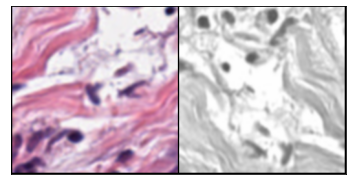

In [ ]:
path = '/content/drive/My Drive/Deep_Learning/final_project/train_npy/'
dir = os.listdir(path)
print(f'num of image: {len(dir)}')
img = np.load(os.path.join(path, dir[0]))
print(img.shape)
img = torch.from_numpy(img)
img = torch.unsqueeze(img, 0)
print(img.shape)
img = torch.squeeze(img, 0)
print(img.shape)
img1, img2 = trans(img)
a = make_grid([img1, img2])
show(a)

#Playground

In [ ]:
#validating phase
model.eval()

valid_losses = []
valid_accuracies = []
valid_label = []
valid_output = []
for image_batch, label_batch in tqdm(validation_dataloader):
    image_batch = image_batch.cuda()
    label_batch = label_batch.cuda()
    output_batch = model(image_batch)
    output_batch = torch.flatten(output_batch)
    # print(output_batch.shape)
    loss = loss_fn(output_batch, label_batch)
    
    loss = loss.detach().cpu().numpy()  
    valid_losses.append(loss)

    output_batch = output_batch.detach().cpu().numpy()
    label_batch = label_batch.detach().cpu().numpy()
    label_batch = np.bool(label_batch)
    # print(f"{output_batch}, {label_batch}")
    valid_label.append(label_batch)
    valid_output.append(output_batch)

##### AUC #####
print(output_batch.shape)
auc = AUC(valid_label, valid_output)
# valid_accuracies.append(auc)

valid_loss = np.mean(valid_losses)
valid_accuracy = np.mean(valid_accuracies)
print(f"Testing loss: {valid_loss}, Testing Accuracy: {valid_accuracy}")

if valid_loss < best_valid_loss:
    best_valid_loss = valid_loss
    torch.save(model.state_dict(), model_path)
    print("The model is saved")

  0%|          | 0/1415 [00:00<?, ?it/s]

(1,)
0.9838018274402412
Testing loss: 0.01030162564479491, Testing Accuracy: nan


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


NameError: ignored

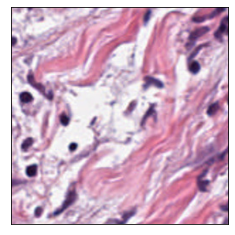

In [ ]:
from torchvision.utils import make_grid

plt.rcParams["savefig.bbox"] = 'tight'

def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = transforms.functional.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

img = os.listdir(train_path)
img1 = read_image(os.path.join(train_path, img[0]), mode=ImageReadMode.RGB)
img2 = transforms.functional.rotate(img1, 90)
img_merge = torch.vstack((img1, img2))
# print(img_merge.shape)
a = make_grid([img_merge[3:6,:,:]])
show(a)

##Import CSV

In [ ]:
df = pd.read_csv (r'/content/drive/My Drive/Deep_Learning/Midterm/train.csv')
# def a():
#     df = pd.read_csv (r'/content/drive/My Drive/Deep_Learning/Midterm/train.csv')
#     return df
# x = a()
# sorted_df = df.sort_values(by="label",kind='mergesort')
# i = df.loc["FOREARM_00f72d1153"]
df.set_index('id', inplace=True)
j = df.loc['FOREARM_000b20cbe3'][0]
print(type(j))
print(type("str"))
# j.reset_index(inplace=True)
df.reset_index(inplace=True)
# print(f"j0: {j[0]}\n")
# print(j['id'][0])
print(j)
print(df)

<class 'numpy.float64'>
<class 'str'>
nan
                      id  label
0     FOREARM_000b20cbe3    NaN
1     FOREARM_000be2e9ab    1.0
2     FOREARM_00192d1b21    NaN
3     FOREARM_0055c4c62a    1.0
4     FOREARM_00f72d1153    0.0
...                  ...    ...
3995    WRIST_ff39824aa4    0.0
3996    WRIST_ff5128afcd    1.0
3997    WRIST_ff60656c01    0.0
3998    WRIST_ffaf60a955    0.0
3999    WRIST_fff3b05bc0    0.0

[4000 rows x 2 columns]


In [ ]:
label = pd.read_csv(f'{path}/validation_ground_truth.csv')
print(f'{label.loc[0][1]}, img1: {label.loc[0][0][:12]}, img2: {label.loc[0][0][13:]}')

0, img1: f4daa45ef04a, img2: e8d7d06cb61f


##Import Data

In [ ]:
train_dataset = torch.tensor([])
transform1 = transforms.Compose([
  transforms.PILToTensor(),
])
print(train_dataset)
for i in range(100):
  img = Image.open(f"{train_path}/{training_data_file[i]}")
  img_tensor = transform1(img)
  a = torch.cat((train_dataset, img_tensor),0)
  # print(a.shape)

tensor([])


KeyboardInterrupt: ignored

#Choose GPU

In [ ]:
import torch
try:
    # Get GPU name, check if it's K80
    GPU_name = torch.cuda.get_device_name()
    if GPU_name[-3:] == "K80":
        print("Get K80! :'( RESTART!")
        exit()  # Restart the session
    else:
        print("Your GPU is {}!".format(GPU_name))
        print(torch.cuda.device_count())
        print("Great! Keep going~")
except RuntimeError as e:
    if e.args == ("No CUDA GPUs are available",):
        print("You are training with CPU! "
              "Please restart!")
        exit()  # Restart the session
    else:
        print("What's wrong here?")
        print("Error message: \n", e)

Your GPU is Tesla P100-PCIE-16GB!
1
Great! Keep going~


#Test Dataloader

In [41]:
from torchvision.utils import make_grid

plt.rcParams["savefig.bbox"] = 'tight'

def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = transforms.functional.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

feature1 batch size: torch.Size([1, 3, 256, 256])
feature2 batch size: torch.Size([1, 3, 256, 256])
labels batch size: torch.Size([1])
dataloader size: 186
torch.Size([3, 256, 256])


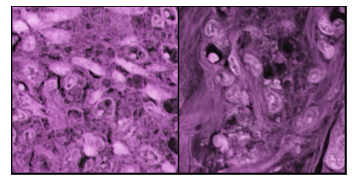

In [75]:
# t = T.ToPILImage()

finetune_features1, finetune_features2, finetune_labels = next(iter(finetune_dataloader))
print(f"feature1 batch size: {finetune_features1.size()}")
print(f"feature2 batch size: {finetune_features2.size()}")
print(f"labels batch size: {finetune_labels.shape}")
print(f"dataloader size: {len(finetune_dataloader)}")

finetune_features2 = finetune_features2.squeeze(0)
finetune_features1 = finetune_features1.squeeze(0)

print(finetune_features2.shape)


finetune_features2[0], finetune_features2[1], finetune_features2[2] = finetune_features2[1], finetune_features2[2], finetune_features2[0]
finetune_features1[0], finetune_features1[1], finetune_features1[2] = finetune_features1[1], finetune_features1[2], finetune_features1[0]

# finetune_features2 = t(finetune_features2)
# finetune_features1 = t(finetune_features1)

label = finetune_labels[0]
a = make_grid([finetune_features1, finetune_features2])
show(a)

# Bottom
